In [249]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
from IPython.core.display import display

In [250]:
df_raw = pd.read_pickle('../testData/scrobbles_processed/5759068.pkl')


# Artist basis

In [251]:
df_raw.index.max()

58832

In [252]:
# def 1: final prop. listens
vc = df_raw['artist_idx'].value_counts()
overall_prop = vc/float(len(df))
overall_prop.name = 'final_value'
df_raw = df_raw.join(overall_prop,on='artist_idx')


In [253]:
# def 2: up-to-moment prop. listens
def calc_c_counts(df):
    df['index'] = range(1,len(df)+1)
    return df
df_raw = df_raw.groupby('artist_idx').apply(calc_c_counts)
df_raw['overall_index'] = df_raw.index + 1
df_raw['current_value'] = df_raw['index'] / df_raw['overall_index']

In [254]:
# def 3: global popularity
artist_pops = pd.Series([line.split(',')[1] for line in open('../GenreModeling/data/artist_pop')],dtype=float)
artist_pops.name = 'global_value'
df_raw = df_raw.join(artist_pops / artist_pops.sum(),on='artist_idx')


In [255]:
### ADD IDF DATA
total_users = 145148.
idf = pd.Series(np.log(total_users / np.loadtxt('../testData/idf_data',dtype=float)))
idf.name = 'idf'
df_raw = df_raw.join(idf,on='artist_idx')


In [256]:
# def 4: tf-idf variant of final prop. listens
df_raw['final_value_tfidf'] = df_raw['final_value'] * df_raw['idf']

In [257]:
# def 5: tf-idf variant of up-to-moment prop. listens
df_raw['current_value_tfidf'] = df_raw['current_value'] * df_raw['idf']

In [259]:
cols = df_raw.columns
#cols = ['artist_idx','ts','final_value','final_value_tfidf','current_value','current_value_tfidf','global_value']
display(df_raw[cols].head())
display(df_raw[cols].tail())

,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,index,overall_index,current_value,global_value,idf,final_value_tfidf,current_value_tfidf
0,NaN,50.0,2007-02-24 22:54:28,0.0,0.0,0.0,0.0,0.008686,1.0,1,1.000000,0.001344,0.872338,0.007577,0.872338
1,0.986968,584.0,2007-02-24 22:59:07,0.0,0.0,1.0,1.0,0.002482,1.0,2,0.500000,0.000267,1.822755,0.004523,0.911378
2,0.765355,231.0,2007-02-24 23:01:54,0.0,0.0,2.0,2.0,0.000119,1.0,3,0.333333,0.000539,0.954154,0.000114,0.318051
3,0.925810,747.0,2007-02-25 01:55:39,0.0,0.0,3.0,3.0,0.005218,1.0,4,0.250000,0.000220,2.160909,0.011276,0.540227
4,0.830164,405.0,2007-02-25 02:00:36,0.0,0.0,4.0,4.0,0.005830,1.0,5,0.200000,0.000368,1.704314,0.009936,0.340863


,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,index,overall_index,current_value,global_value,idf,final_value_tfidf,current_value_tfidf
58828,0.0,810.0,2012-12-29 22:06:38,0.0,4044.0,24313.0,22804.0,0.006969,406.0,58829,0.006901,0.000203,2.666308,0.018581,0.018401
58829,0.0,810.0,2012-12-29 22:09:57,0.0,4044.0,24313.0,22804.0,0.006969,407.0,58830,0.006918,0.000203,2.666308,0.018581,0.018446
58830,0.0,810.0,2012-12-29 22:13:33,0.0,4044.0,24313.0,22804.0,0.006969,408.0,58831,0.006935,0.000203,2.666308,0.018581,0.018491
58831,0.0,810.0,2012-12-29 22:16:42,0.0,4044.0,24313.0,22804.0,0.006969,409.0,58832,0.006952,0.000203,2.666308,0.018581,0.018536
58832,0.0,810.0,2012-12-29 22:20:38,0.0,4044.0,24313.0,22804.0,0.006969,410.0,58833,0.006969,0.000203,2.666308,0.018581,0.018581


(0, 0.04)

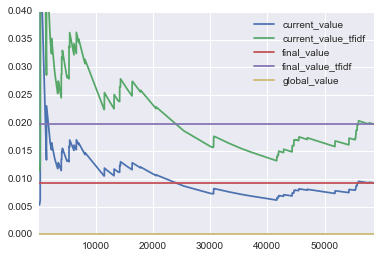

In [190]:
fig,ax = plt.subplots(1,1)
df_raw[df_raw['artist_idx']==1149][['current_value','current_value_tfidf','final_value','final_value_tfidf','global_value']].plot(ax=ax)
ax.set_ylim(0,0.04)

# Patch basis

In [286]:
df_patches_raw = pd.read_pickle('../testData/patches_clustered/5759068.pkl')

In [287]:
# def 1: final prop. listens
#vc = df_patches['patch_clust'].value_counts()
listensPerPatch = df_patches.groupby('patch_clust')['n'].sum()
overall_prop = listensPerPatch/float(df_patches['n'].sum())
overall_prop_exploit = listensPerPatch/float(df_patches.dropna()['n'].sum())
overall_prop.name = 'final_value'
overall_prop_exploit.name = 'final_value_exploit'
df_patches_raw = df_patches_raw.join(overall_prop,on='patch_clust').join(overall_prop_exploit,on='patch_clust')


In [288]:
def calc_c_counts(df):
    df['index'] = df['n'].cumsum()
    return df
df_patches = df_patches_raw.groupby('patch_clust').apply(calc_c_counts)
df_patches['n'] = df_patches_raw['n']
df_patches['overall_index'] = df_patches['n'].cumsum()
df_patches['current_value'] = df_patches['index'] / df_patches['overall_index']
df_patches['overall_exploit_index'] = np.where(np.isnan(df_patches['patch_clust']),0,df_patches['n']).cumsum()
df_patches['current_value_exploit'] = df_patches['index'] / df_patches['overall_exploit_index']

In [296]:
df_patches[['n','patch_clust','final_value','final_value_exploit','current_value','current_value_exploit']].head(10)

,n,patch_clust,final_value,final_value_exploit,current_value,current_value_exploit
0,69,NaN,NaN,NaN,NaN,NaN
1,16,91.0,0.024017,0.039736,0.188235,1.000000
2,13,53.0,0.008550,0.014145,0.132653,0.448276
3,12,NaN,NaN,NaN,NaN,NaN
4,8,90.0,0.015009,0.024831,0.067797,0.216216
5,24,128.0,0.021553,0.035658,0.169014,0.393443
6,3,NaN,NaN,NaN,NaN,NaN
7,11,128.0,0.021553,0.035658,0.224359,0.486111
8,63,NaN,NaN,NaN,NaN,NaN
9,14,53.0,0.008550,0.014145,0.115880,0.313953


In [290]:
df_patches['final_value'].describe()

count    2626.000000
mean        0.015616
std         0.013647
min         0.000085
25%         0.004275
50%         0.009281
75%         0.024017
max         0.040369
Name: final_value, dtype: float64

In [299]:
### TEST
def calc_c_counts(df):
    df['index'] = df['n'].cumsum()
    return df



df_raw = pd.read_pickle('../testData/patches_clustered/5759068.pkl')
#user = fi.split('/')[-1].split('_')[0]

listensPerPatch = df_raw.groupby('patch_clust')['n'].sum()
overall_prop = listensPerPatch/float(df_raw['n'].sum())
overall_prop_exploit = listensPerPatch/float(df_raw.dropna()['n'].sum())
overall_prop.name = 'final_value'
overall_prop_exploit.name = 'final_value_exploit'
df = df_raw.join(overall_prop,on='patch_clust').join(overall_prop_exploit,on='patch_clust')

df = df.groupby('patch_clust').apply(calc_c_counts)
df['n'] = df_raw['n']
df['overall_index'] = df['n'].cumsum()
df['current_value'] = df['index'] / df['overall_index']
df['overall_exploit_index'] = np.where(np.isnan(df['patch_clust']),0,df['n']).cumsum()
df['current_value_exploit'] = df['index'] / df['overall_exploit_index']


In [301]:
df[['n','patch_clust']]

,centroid,diversity,n,start_ts,patch_clust,final_value,final_value_exploit,index,overall_index,current_value,overall_exploit_index,current_value_exploit
4040,"[8.73599576199e-07, 8.73599576199e-07, 0.06511...",0.00000,10,2012-12-23 18:39:45,82.0,0.021739,0.035967,1279.0,58781,0.021759,35513,0.036015
4041,"[0.035015218375, 0.00100713177281, 0.011293278...",0.04538,13,2012-12-27 06:28:31,109.0,0.002380,0.003937,140.0,58794,0.002381,35526,0.003941
4042,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,58799,NaN,35526,NaN
4043,"[0.00117974237337, 0.000368630135718, 0.001656...",0.00000,26,2012-12-28 12:45:58,81.0,0.035728,0.059111,2102.0,58825,0.035733,35552,0.059125
4044,"[3.24932422179e-07, 0.000967128861375, 0.00077...",0.00000,8,2012-12-29 21:55:51,93.0,0.006595,0.010911,388.0,58833,0.006595,35560,0.010911
